## Garment Segmentation Project

### Basic U-Net architecture models and image segmentation 

### The Data

For details about preprocessing the data please refer to the Jupyter notebook: Garment_Segmentation_Preprocessing.ipynb.

Note: 
- All ML imagery will be resized to 256x256. The main reason is that it reduced computational overhead resulting in a faster/shorter feedback loop in terms of what works and what does not
- I only split by dataset into training and validation sets in this initial exploratory phase of finding a workable model. Later on when we look at fine tuning the model I will introduce an additional 100ish images for testing to establish the final performance of the model choosen.

In [1]:
import os
import cv2     
import glob
import numpy as np
from tqdm import tqdm
from keras.preprocessing import image                  
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from skimage import exposure

# Load our 1084 original training images
file_img_paths = sorted(glob.glob("./input_CP/original/*.png"))
# Load 1084 cutout mask training images
file_seg_paths = sorted(glob.glob("./input_CP/masks/*.png"))     
    
# Fixed split of dataset containg 1084 original garment images and 1084 binary masks.
orig_train = file_img_paths[0:900]
orig_valid = file_img_paths[900:]
seg_train = file_seg_paths[0:900]
seg_valid = file_seg_paths[900:]

def path_to_tensor(img_path, is_mask):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) if is_mask else cv2.imread(img_path)
    img_scaled = cv2.resize(img, (256, 256))
    x = image.img_to_array(img_scaled)
    x = np.expand_dims(x, axis=0)
    return x

def paths_to_tensor(img_paths, is_mask):
    list_of_tensors = [path_to_tensor(img_path, is_mask) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

orig_train_tensors = paths_to_tensor(orig_train, False).astype('float32')/255
seg_train_tensors = paths_to_tensor(seg_train, True).astype('float32')/255
orig_valid_tensors = paths_to_tensor(orig_valid, False).astype('float32')/255
seg_valid_tensors = paths_to_tensor(seg_valid, True).astype('float32')/255

#Calculate the mean and std for each pixel
orig_mean = orig_train_tensors.mean(axis=(0), keepdims=True)
orig_std = orig_train_tensors.std(axis=(0), keepdims=True)

orig_train_tensors -= orig_mean # center distribution
orig_train_tensors /= orig_std # normalize

orig_valid_tensors -= orig_mean # center distribution
orig_valid_tensors /= orig_std # normalize

print('Shape of image training set: ' + str(orig_train_tensors.shape))
print('Shape of mask training set: ' + str(seg_train_tensors.shape))
print('Shape of image validation set: ' + str(orig_valid_tensors.shape))
print('Shape of mask validation set: ' + str(seg_valid_tensors.shape))

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
100%|██████████| 184/184 [00:02<00:00, 88.50it/s]


Shape of image training set: (900, 256, 256, 3)
Shape of mask training set: (900, 256, 256, 1)
Shape of image validation set: (184, 256, 256, 3)
Shape of mask validation set: (184, 256, 256, 1)


### A Simple U-Net Model

The Unet paper (https://arxiv.org/abs/1505.04597) present itself as a way to do image segmentation for biomedical data. It turns out you can use it for various image segmentation problems such as the one we will work on. In our case, using a U-Net is a good choice because of the lack of training data. This neural network architecture has revealed to be very good in this situation. U-Nets have an ability to learn in environments of low to medium quantities of training data, and the amount of training data available to us is considered low.

A U-Net is like a convolutional autoencoder, but it also has skip-like connections with the feature maps located before the bottleneck (compressed embedding) layer, in such a way that in the decoder part some information comes from previous layers, bypassing the compressive bottleneck.

See the figure below, taken from the official paper of the U-Net , which also illustrates why it is called a U-Net model:
<img src='./images/u-net_cnn.png'>


Thus, in the decoder, data is not only recovered from a compression, but is also concatenated with the information’s state before it is passed into the compression bottleneck so as to augment context for the next decoding layers to come. That way, the neural networks still learns to generalize in the compressed latent representation (located at the bottom of the “U” shape in the figure), but also recovers its latent generalizations to a spatial representation with the proper per-pixel semantic alignment in the right part of the U of the U-Net.

Let's build a simple model, about the simplest possible U-Net model:

Encoding:

- it will receive as input a color image with a resolution of 256x256 so input 256x256x3
- it will have only one layer for encoding in form of a block consisting of:
    - 2D convolution consisting of 32 filters, a (3, 3) kernel, default strides of (1, 1), padding is same, meaning, output size is the same as input size, requires the filter window to slip outside input map, hence the need to pad
    - a batch normalisation to handle covariance shift and helps the model converge faster, more on this later
    - the traditional activation function of ReLU
- next down-sampling the input via max polling (256x256 --> 128x128). Done to help over-fitting by providing an abstracted form of the representation, as well as, reduce the computational cost by reducing the number of parameters to learn and provides basic translation invariance to the internal representation

Bottleneck:

- follow the same principle as described above for the first block. The only difference is that here we generate 128 filters, that is, increases the depth of our feature map stack to 128

Decoder:

- upsampling of the feature map followed by a 2x2 convolution (“up-convolution”) that halves the number of feature channels (128x128) --> 256x256)
- concatenation with the correspondingly cropped feature map from the contracting path. The cropping is necessary due to the loss of border pixels in every convolution
- next followes our normal convolutional block

Classification:

- the final layer a 1x1 convolution is used to map each 32-component feature vector to one class, namely a garment class. In other words it is the probability per pixel of being garment or not.

The model is visualised here and the code follows in the next cell.
<img src='./images/U-Net_model_small.png'>


In [5]:
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization

def simple_unet_256_segmentation_model(input_shape=(256, 256, 3), num_classes=1):
    inputs = Input(shape=input_shape) # 256

    down = Conv2D(32, (3, 3), padding='same')(inputs)
    down = BatchNormalization()(down)
    down = Activation('relu')(down)
    down_pool = MaxPooling2D((2, 2), strides=(2, 2))(down) #128

    center = Conv2D(128, (3, 3), padding='same')(down_pool)
    center = BatchNormalization()(center)
    center = Activation('relu')(center) # center

    up = UpSampling2D((2, 2))(center)
    up = concatenate([down, up], axis=3)
    up = Conv2D(32, (3, 3), padding='same')(up)
    up = BatchNormalization()(up)
    up = Activation('relu')(up) # 256

    classify = Conv2D(num_classes, (1, 1), activation='sigmoid')(up)

    model = Model(inputs=inputs, outputs=classify)

    return model


Using TensorFlow backend.


In [29]:
simple_model = simple_unet_256_segmentation_model()
simple_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 256, 256, 32) 896         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 256, 256, 32) 128         conv2d_23[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 256, 256, 32) 0           batch_normalization_19[0][0]     
__________________________________________________________________________________________________
max_poolin


### Introducing our own loss funtions

The Dice coefficient (F1 score) is the main metrics for measuring the performance of the segmentation work (together with the IoU: intersection over Union). Reason for selecting this coefficient is that it is a well known, understood and accepted industry standard for measuring the performance of segmentation work.

Dice coefficient = 2 * |X ∩ Y| / (|X|+|Y|)

As we are aiming for a perfect overlap, dice coefficient of 1, why not build it into the loss function itself as illustrated in below code where we weigh the Dice coefficient 4 times above the BCE. We add BCE to the loss function as it is a binary problem in form of garment versus background. 

In [10]:
import keras.backend as K
from keras.losses import binary_crossentropy, mean_squared_error

def dice_coeff(y_true, y_pred):
    smooth = 1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    loss = 0.5 * binary_crossentropy(y_true, y_pred) - 2*dice_coeff(y_true, y_pred)
    return loss


Next we ask the model to use RMSprop as optimizer with fixed learning rate of 3e-4. We tell the model to use our own loss function we just discussed and finally we select the metrics to use as the Dice coefficient along with pixel accuracy.

In [31]:
from keras.optimizers import RMSprop

simple_model.compile(optimizer=RMSprop(lr=0.0003), loss=bce_dice_loss, metrics=[dice_coeff, 'accuracy'])

### Illustrate of our progress

To help visualise how the model performs in terms of accuracy, loss and Dice coefficient per epoch I have written below helper function which is to be run after training.

In [11]:
# A little plot helper allowing us to visualise the result
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    dice_coeff = history.history['dice_coeff']
    val_dice_coeff = history.history['val_dice_coeff']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r.')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')

    plt.figure()

    plt.plot(epochs, loss, 'r.')
    plt.plot(epochs, val_loss, 'r-')
    plt.title('Training and validation loss')

    plt.figure()

    plt.plot(epochs, dice_coeff, 'r.')
    plt.plot(epochs, val_dice_coeff, 'r-')
    plt.title('Training and validation Dice coef.')

    plt.show()

### Training time!!!

Finally we are ready to train out simple model. We train it my calling the fit method of the Keras Model. It it supplied with the four tensors (2 x training, 2 x validation) and a higher batch size which should help speed up convergence of the model. Additionally I have supplied three callback functions:
- EarlyStopping as no reason to continue training a model that is not improving. Have set a patience to 20 meaning that if after 20 epochs the model has not improved its metric by at least 1e-4 then stop training any further
- ModelCheckpoint to save the weights that brought about an improvement in our metric, here validation loss
- TensorBoard to safe a log that can subsequently be analysed for metric improvements against epochs etc (advanced version of my simple plot function above)

Train on 900 samples, validate on 184 samples
Epoch 1/50
900/900 [==============================] - 36s 40ms/step - loss: -0.1226 - acc: 0.7292 - dice_coeff: 0.2377 - val_loss: -0.2095 - val_acc: 0.7897 - val_dice_coeff: 0.2490
Epoch 2/50
900/900 [==============================] - 32s 36ms/step - loss: -0.2949 - acc: 0.8366 - dice_coeff: 0.2793 - val_loss: -0.1890 - val_acc: 0.7882 - val_dice_coeff: 0.2353
Epoch 3/50
900/900 [==============================] - 32s 36ms/step - loss: -0.3789 - acc: 0.8779 - dice_coeff: 0.3006 - val_loss: -0.3516 - val_acc: 0.8786 - val_dice_coeff: 0.2842
Epoch 4/50
900/900 [==============================] - 32s 36ms/step - loss: -0.4451 - acc: 0.8964 - dice_coeff: 0.3200 - val_loss: -0.3989 - val_acc: 0.8400 - val_dice_coeff: 0.3315
Epoch 5/50
900/900 [==============================] - 32s 36ms/step - loss: -0.5028 - acc: 0.9120 - dice_coeff: 0.3389 - val_loss: -0.3130 - val_acc: 0.8217 - val_dice_coeff: 0.3276
Epoch 6/50
900/900 [========================

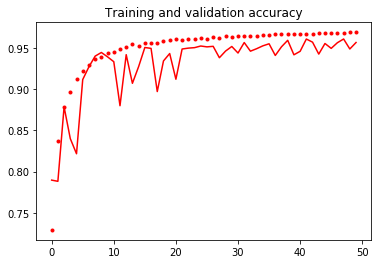

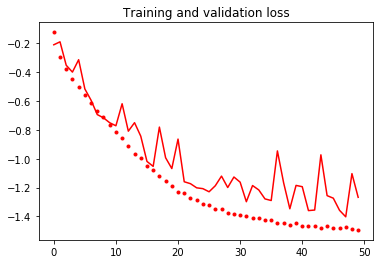

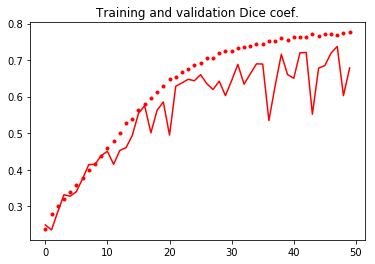

In [32]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

weight_file_name = 'Simple_U-Net_Model_010518'

batch_size = 24
epochs = 50

callbacks = [EarlyStopping(monitor='val_loss', patience=20, verbose=2, min_delta=1e-4),
             ModelCheckpoint(monitor='val_loss', filepath='./weights/' + str(weight_file_name) + '.hdf5', 
                             save_best_only=True, save_weights_only=True),
            TensorBoard(log_dir='./logs')]


history = simple_model.fit(orig_train_tensors, seg_train_tensors, batch_size=batch_size, epochs=epochs, verbose=1, 
          validation_data=(orig_valid_tensors, seg_valid_tensors), callbacks=callbacks)

plot_training(history)


#### Result of simple model

Please refer to the graphs that have been generate as fitting the data to the model. What we see:
- The model converges nicely and reasonable fast
- We have achieved accuracies around 97% for training data and around 96% for validation data
- The model is constanly learning as we observ how both training and validation loss keeps getting smaller. However a tendency for overfitting starts to appear around 20 epochs as the gab between training and validation scores starts opening up
- Both the training and validation Dice coefficients are showing good promish. Validation maxing out around 74% and training maxing out at 78%. Also clear that this is the best possible generalising performance we can expect with such a simple model.

Not a bad start but we can do better. Below model is identical compared to the simple model in that it contains the same structure and the same elements. Only difference it has many more layers and much biggger feature map sizes (much higher entropic capacity).


### A Basic U-Net model

Not a bad start but we can do better. Below model is identical compared to the simple model in that it contains the same structure and the same elements. Only difference, it has many more layers and much bigger feature map sizes (much higher entropic capacity). In this 5 layer model we 1/2 the 2-D dimensions of the feature maps per layer but increase the amount of filters per layer by a factor of 2 or 4:

Encoder (per layer, 4 in total):
- Convolutional block (Con2D --> BN --> activation)
- Max polling (1/2 the size (dimension) of the feature maps)

Bottleneck:
- The same just many more filters

Decoder (per layer, 4 in total):
- The same just many more filters

All of this resulting in 61,963,281 trainable parameters - we have entropic capacity now. In terms of getting to a trainable result everything is kept like in the simple model case.

Introducing the basic model below:

In [14]:
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization

def basic_unet_256_segmentation_model(input_shape=(256, 256, 3), num_classes=1):
    inputs = Input(shape=input_shape) # 256

    down0 = Conv2D(32, (3, 3), padding='same')(inputs)
    down0 = BatchNormalization()(down0)
    down0 = Activation('relu')(down0)
    down0_pool = MaxPooling2D((2, 2), strides=(2, 2))(down0) #128

    down1 = Conv2D(128, (3, 3), padding='same')(down0_pool)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1) # 64

    down2 = Conv2D(512, (3, 3), padding='same')(down1_pool)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down2) # 32

    down3 = Conv2D(1048, (3, 3), padding='same')(down2_pool)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3_pool = MaxPooling2D((2, 2), strides=(2, 2))(down3) # 16

    center = Conv2D(2048, (3, 3), padding='same')(down3_pool)
    center = BatchNormalization()(center)
    center = Activation('relu')(center) # center

    up3 = UpSampling2D((2, 2))(center)
    up3 = concatenate([down3, up3], axis=3)
    up3 = Conv2D(1048, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3) # 32

    up2 = UpSampling2D((2, 2))(up3)
    up2 = concatenate([down2, up2], axis=3)
    up2 = Conv2D(512, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2) # 64

    up1 = UpSampling2D((2, 2))(up2)
    up1 = concatenate([down1, up1], axis=3)
    up1 = Conv2D(128, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1) # 128

    up0 = UpSampling2D((2, 2))(up1)
    up0 = concatenate([down0, up0], axis=3)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0) # 256

    classify = Conv2D(num_classes, (1, 1), activation='sigmoid')(up0)

    model = Model(inputs=inputs, outputs=classify)

    return model

In [15]:
basic_model = basic_unet_256_segmentation_model()
basic_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 256, 256, 32) 896         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 256, 256, 32) 128         conv2d_21[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 256, 256, 32) 0           batch_normalization_19[0][0]     
__________________________________________________________________________________________________
max_poolin

In [16]:
from keras.optimizers import RMSprop

basic_model.compile(optimizer=RMSprop(lr=0.0003), loss=bce_dice_loss, metrics=['accuracy', dice_coeff])

Train on 900 samples, validate on 184 samples
Epoch 1/50
900/900 [==============================] - 169s 188ms/step - loss: -0.6746 - acc: 0.9151 - dice_coeff: 0.4195 - val_loss: -4.4598e-04 - val_acc: 0.8277 - val_dice_coeff: 0.3392
Epoch 2/50
900/900 [==============================] - 160s 178ms/step - loss: -1.0388 - acc: 0.9762 - dice_coeff: 0.5583 - val_loss: 0.4548 - val_acc: 0.7619 - val_dice_coeff: 0.3204
Epoch 3/50
900/900 [==============================] - 160s 178ms/step - loss: -1.1678 - acc: 0.9825 - dice_coeff: 0.6147 - val_loss: -1.0369 - val_acc: 0.9841 - val_dice_coeff: 0.5549
Epoch 4/50
900/900 [==============================] - 161s 179ms/step - loss: -1.2866 - acc: 0.9881 - dice_coeff: 0.6670 - val_loss: -1.1573 - val_acc: 0.9826 - val_dice_coeff: 0.6095
Epoch 5/50
900/900 [==============================] - 160s 178ms/step - loss: -1.3681 - acc: 0.9896 - dice_coeff: 0.7043 - val_loss: -0.5184 - val_acc: 0.8616 - val_dice_coeff: 0.4588
Epoch 6/50
900/900 [===========

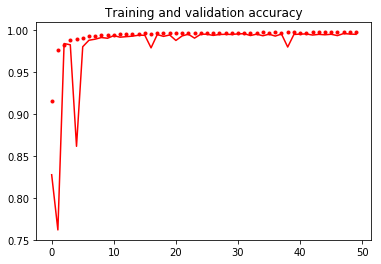

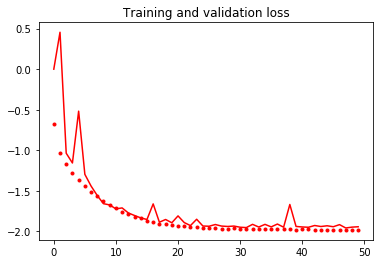

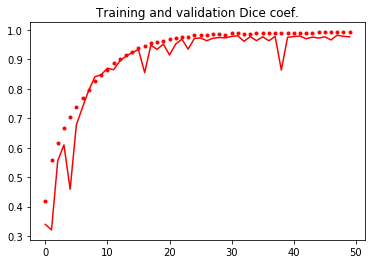

In [17]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

weight_file_name = 'Basic_U-Net_Model_010518'

batch_size = 24
epochs = 50

callbacks = [EarlyStopping(monitor='val_loss', patience=20, verbose=2, min_delta=1e-4),
             ModelCheckpoint(monitor='val_loss', filepath='./weights/' + str(weight_file_name) + '.hdf5', 
                             save_best_only=True, save_weights_only=True),
            TensorBoard(log_dir='./logs')]


history = basic_model.fit(orig_train_tensors, seg_train_tensors, batch_size=batch_size, epochs=epochs, verbose=1, 
          validation_data=(orig_valid_tensors, seg_valid_tensors), callbacks=callbacks)

plot_training(history)

The results demonstrated above shows:
- The model converges nicely and reasonable fast. Much less variation than earlier. 
- All graphs shows how well the validation performance match the training performance indicating that this model has strong generalisation capabilities
- We have achieved pixel accuracies around 99.75% for training data and around 99.60% for validation data
- The model is constanly learning as we observ how both training and validation loss keeps getting smaller
- Both the training and validation Dice coefficients are showing great promish. Training maxing out around 99.24% and validation maxing out at 98.26%.
- No sign of overfitting at all
 
A great start in our purcuit of automatically cutting out garments. The extra layers and expanded feature map set has paid of very well. We are allmost reached out target range for the Dice Coefficient.

### The final U-Net model

The final model we will use going forwards comes from Heng CherKeng's constribution to the Kaggle Carvana Image Masking Challenge. He code was based on PyTorch but a Keras implementation was made available by Peter Giannakopoulos here: https://github.com/petrosgk/Kaggle-Carvana-Image-Masking-Challenge.
No reason to reinvent the wheel so we gratefully thank both of them for sharing there work. 

There model is very similar to our basic model. There are no new features we haven't already discussed. In this 6 layer model 2-D dimensions of the feature maps are consistently halved per layer while the number of filters are doubled. The main difference lies within a layer they use double and triple convolutional blocks versus our single convolutional block:

Encoder (per layer, 5 in total):
- 2 x Convolutional block (Con2D --> BN --> activation)
- Max polling (1/2 the size of the feature maps)

Bottleneck:
- 2 x Convolutional block (Con2D --> BN --> activation) with more filters

Decoder (per layer, 5 in total):
- Upsampling and concatenation as before
- 3 x Convolutional block (Con2D --> BN --> activation)



Introducing the final model:

In [6]:
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization

def final_unet_256_segmentation_model(input_shape=(256, 256, 3), num_classes=1):
    inputs = Input(shape=input_shape) # 256

    down0 = Conv2D(32, (3, 3), padding='same')(inputs)
    down0 = BatchNormalization()(down0)
    down0 = Activation('relu')(down0)
    down0 = Conv2D(32, (3, 3), padding='same')(down0)
    down0 = BatchNormalization()(down0)
    down0 = Activation('relu')(down0)
    down0_pool = MaxPooling2D((2, 2), strides=(2, 2))(down0) # 128

    down1 = Conv2D(64, (3, 3), padding='same')(down0_pool)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1 = Conv2D(64, (3, 3), padding='same')(down1)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1) # 64

    down2 = Conv2D(128, (3, 3), padding='same')(down1_pool)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2 = Conv2D(128, (3, 3), padding='same')(down2)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down2) # 32

    down3 = Conv2D(256, (3, 3), padding='same')(down2_pool)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3 = Conv2D(256, (3, 3), padding='same')(down3)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3_pool = MaxPooling2D((2, 2), strides=(2, 2))(down3) # 16

    down4 = Conv2D(512, (3, 3), padding='same')(down3_pool)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4 = Conv2D(512, (3, 3), padding='same')(down4)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4_pool = MaxPooling2D((2, 2), strides=(2, 2))(down4) # 8

    center = Conv2D(1024, (3, 3), padding='same')(down4_pool)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    center = Conv2D(1024, (3, 3), padding='same')(center)
    center = BatchNormalization()(center)
    center = Activation('relu')(center) # center

    up4 = UpSampling2D((2, 2))(center)
    up4 = concatenate([down4, up4], axis=3)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4) # 16

    up3 = UpSampling2D((2, 2))(up4)
    up3 = concatenate([down3, up3], axis=3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3) # 32

    up2 = UpSampling2D((2, 2))(up3)
    up2 = concatenate([down2, up2], axis=3)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2) # 64

    up1 = UpSampling2D((2, 2))(up2)
    up1 = concatenate([down1, up1], axis=3)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1) # 128

    up0 = UpSampling2D((2, 2))(up1)
    up0 = concatenate([down0, up0], axis=3)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0) # 256

    classify = Conv2D(num_classes, (1, 1), activation='sigmoid')(up0)

    model = Model(inputs=inputs, outputs=classify)
    
    return model

In [7]:
final_model = final_unet_256_segmentation_model()
final_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 256, 256, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 256, 256, 32)  896         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 256, 256, 32)  128         conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 256, 256, 32)  0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [12]:
from keras.optimizers import RMSprop

final_model.compile(optimizer=RMSprop(lr=0.0003), loss=bce_dice_loss, metrics=['accuracy', dice_coeff])

In [15]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

weight_file_name = 'Final_U-Net_Model_020518'

batch_size = 8
epochs = 100

callbacks = [EarlyStopping(monitor='val_loss', patience=20, verbose=2, min_delta=1e-4),
             ModelCheckpoint(monitor='val_loss', filepath='./weights/' + str(weight_file_name) + '.hdf5', 
                             save_best_only=True, save_weights_only=True),
            TensorBoard(log_dir='./logs')]


history = final_model.fit(orig_train_tensors, seg_train_tensors, batch_size=batch_size, epochs=epochs, verbose=1, 
          validation_data=(orig_valid_tensors, seg_valid_tensors), callbacks=callbacks)

plot_training(history)

Quick summary below of training the final model (please refer to separate notebook unet_256_with_mean-std_preprocessing.ipynb for all details):

Best score happened at epoch 64:

Epoch 64/100 <BR>
*900/900 [==============================] - 105s 117ms/step - loss: -1.9852 - acc: 0.9977 - dice_coeff: 0.9936 - val_loss: -1.9706 - val_acc: 0.9967 - val_dice_coeff: 0.9882*

Early stopping kicked in at epoch 84:

Epoch 84/100 <BR>
*900/900 [==============================] - 105s 116ms/step - loss: -1.9871 - acc: 0.9978 - dice_coeff: 0.9944 - val_loss: -1.9683 - val_acc: 0.9966 - val_dice_coeff: 0.9877* <BR>
*Epoch 00084: early stopping* 

<img src='./images/Unet_final_model_training_acc.png'>
<img src='./images/Unet_final_model_training_loss.png'>
<img src='./images/Unet_final_model_training_dice.png'>



#### Results of Final Model

Please refer to the graphs that resulted as fitting the data to the model. What we see:
- The model converges nicely and very fast and again with much less variation than earlier. 
- All graphs shows how well the validation performance match the training performance indicating that this model has strong generalisation capabilities
- We have achieved pixel accuracies around 99.78% for training data and around 99.67% for validation data
- The model is constanly learning as we observ how both training and validation loss keeps getting smaller, at least up to  60-70 epochs after which we don't detects further improvements and early stopping kicks in (patience = 20)
- Validation Dice coefficient are showing great promish, validation maxing out at 98.82%.
- No worries in terms of overfitting (a slight gab does start appearing around 55-60 epochs, meaning I could have used a more strict early stopping criteria)

A great result. The extra layers and the extra convolutions have paid off!